#Imports

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=f65ceb761bc7f6342d408a19f8b1510a815c948a06fca62db8cc5106ce06525f
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 14.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import os
import numpy as np
from typing import Dict, Tuple
from sklearn.preprocessing import StandardScaler
import ta
import time

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
os.chdir("drive/My Drive/stockhack/")

#Preprocessing

In [6]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
from sklearn.preprocessing import StandardScaler
import ta

class StockPreprocessor:
    def __init__(self):
        self.scalers: Dict[str, StandardScaler] = {}
        self.stock_files = {
            'CELH': 'celh_data.csv',
            'CVNA': 'cvna_data.csv',
            'UPST': 'upst_data.csv',
            'ALT': 'alt_data.csv',
            'FUBO': 'fubo_data.csv'
        }

    def load_all_data(self) -> pd.DataFrame:
        """Load and combine all stock data."""
        all_data = []

        for stock, file in self.stock_files.items():
            df = pd.read_csv(file)
            # Parse dates using DD/MM/YYYY format
            df['Dates'] = pd.to_datetime(df['Dates'], format='%d/%m/%Y')
            all_data.append(df)

        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df.sort_values(['Dates', 'Stock']).reset_index(drop=True)

    def add_technical_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add technical indicators and derived features."""
        df = df.drop(['Moving Average 20 Day.1'], axis=1, errors='ignore')

        # Group by stock to calculate features for each stock separately
        dfs = []

        for stock in df['Stock'].unique():
            stock_df = df[df['Stock'] == stock].copy()

            # Sort by date
            stock_df = stock_df.sort_values('Dates')

            # Forward fill price data
            price_cols = ['Last Price', 'Open Price', 'High Price', 'Low Price',
                         'Bid Price', 'Ask Price', 'VWAP Price']
            stock_df[price_cols] = stock_df[price_cols].ffill().bfill()

            # Fill volume data with rolling median
            vol_cols = ['Volume', 'Average Volume 30 Day', 'Turnover / Traded Value']
            for col in vol_cols:
                stock_df[col] = stock_df[col].fillna(stock_df[col].rolling(30, min_periods=1).median())

            # Fill technical indicators with rolling median
            tech_cols = ['RSI 14 Day', 'Moving Average 20 Day', 'Moving Average 50 Day',
                        'Moving Average 200 Day', 'Volatility 30 Day', 'Current Market Cap']
            for col in tech_cols:
                stock_df[col] = stock_df[col].fillna(stock_df[col].rolling(20, min_periods=1).median())

            # After filling NaN values, calculate technical indicators
            close = stock_df['Last Price']
            high = stock_df['High Price']
            low = stock_df['Low Price']
            volume = stock_df['Volume']

            # Add momentum indicators
            stock_df['ROC_5'] = ta.momentum.ROCIndicator(close, window=5).roc()
            stock_df['ROC_10'] = ta.momentum.ROCIndicator(close, window=10).roc()
            stock_df['ROC_20'] = ta.momentum.ROCIndicator(close, window=20).roc()

            # Add MACD
            macd = ta.trend.MACD(close)
            stock_df['MACD'] = macd.macd()
            stock_df['MACD_Signal'] = macd.macd_signal()
            stock_df['MACD_Diff'] = macd.macd_diff()

            # Add Bollinger Bands
            bollinger = ta.volatility.BollingerBands(close)
            stock_df['BB_High'] = bollinger.bollinger_hband()
            stock_df['BB_Mid'] = bollinger.bollinger_mavg()
            stock_df['BB_Low'] = bollinger.bollinger_lband()
            stock_df['BB_Width'] = (stock_df['BB_High'] - stock_df['BB_Low']) / stock_df['BB_Mid']

            # Add ATR
            stock_df['ATR'] = ta.volatility.AverageTrueRange(high, low, close).average_true_range()

            # Add volume indicators
            stock_df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close, volume).on_balance_volume()
            stock_df['ADI'] = ta.volume.AccDistIndexIndicator(high, low, close, volume).acc_dist_index()

            # Add price-derived features
            stock_df['Daily_Return'] = close.pct_change()
            stock_df['Log_Return'] = np.log(close/close.shift(1))
            stock_df['High_Low_Range'] = (high - low) / close

            # Add MA ratios
            stock_df['Price_MA_Ratio_20'] = close / stock_df['Moving Average 20 Day']
            stock_df['Price_MA_Ratio_50'] = close / stock_df['Moving Average 50 Day']
            stock_df['Price_MA_Ratio_200'] = close / stock_df['Moving Average 200 Day']

            # Add distance to MAs
            stock_df['Distance_To_MA_20'] = (close - stock_df['Moving Average 20 Day']) / stock_df['Moving Average 20 Day']
            stock_df['Distance_To_MA_50'] = (close - stock_df['Moving Average 50 Day']) / stock_df['Moving Average 50 Day']

            # Add volume indicators
            stock_df['Volume_MA_Ratio'] = volume / stock_df['Average Volume 30 Day']
            stock_df['Volume_Price_Trend'] = (close.pct_change() * volume).rolling(5).mean()

            # Fill any remaining NaN values with 0
            stock_df = stock_df.fillna(0)

            dfs.append(stock_df)

        return pd.concat(dfs, ignore_index=True)

    def prepare_data_for_modeling(self, df: pd.DataFrame, window_size: int = 252,  # One year of trading days
                              val_size: int = 63,  # ~3 months
                              test_size: int = 21,  # ~1 month
                              target_days: int = 5) -> Tuple[Dict[str, np.ndarray], ...]:
      """
      Prepare data for modeling using rolling windows approach.

      Args:
          df: Processed DataFrame
          window_size: Number of days for training window
          val_size: Number of days for validation
          test_size: Number of days for testing
          target_days: Number of days ahead to predict
      """
      feature_cols = [
          # Price features
          'Last Price', 'Open Price', 'High Price', 'Low Price',
          'Moving Average 20 Day', 'Moving Average 50 Day', 'Moving Average 200 Day',

          # Volume features
          'Volume', 'Average Volume 30 Day',

          # Technical indicators
          'RSI 14 Day', 'Volatility 30 Day',
          'ROC_5', 'ROC_10', 'ROC_20',
          'MACD', 'MACD_Signal', 'MACD_Diff',
          'BB_High', 'BB_Mid', 'BB_Low', 'BB_Width', 'ATR',
          'OBV', 'ADI',

          # Derived features
          'Daily_Return', 'Log_Return', 'High_Low_Range',
          'Price_MA_Ratio_20', 'Price_MA_Ratio_50', 'Price_MA_Ratio_200',
          'Distance_To_MA_20', 'Distance_To_MA_50',
          'Volume_MA_Ratio', 'Volume_Price_Trend'
      ]

      X_train_dict = {}
      X_val_dict = {}
      X_test_dict = {}
      y_train_dict = {}
      y_val_dict = {}
      y_test_dict = {}

      for stock in df['Stock'].unique():
          # Get data for this stock
          stock_df = df[df['Stock'] == stock].copy()
          stock_df = stock_df.sort_values('Dates')

          # Create target variable (future returns)
          stock_df['target'] = stock_df['Last Price'].shift(-target_days) / stock_df['Last Price'] - 1

          # Get the last window of data
          total_size = window_size + val_size + test_size
          final_window = stock_df.iloc[-total_size:].copy()

          # Split into train/val/test
          train_data = final_window.iloc[:window_size]
          val_data = final_window.iloc[window_size:window_size + val_size]
          test_data = final_window.iloc[window_size + val_size:]

          # Scale features using only training data
          scaler = StandardScaler()
          train_features = scaler.fit_transform(train_data[feature_cols])
          val_features = scaler.transform(val_data[feature_cols])
          test_features = scaler.transform(test_data[feature_cols])

          # Store splits
          X_train_dict[stock] = train_features
          X_val_dict[stock] = val_features
          X_test_dict[stock] = test_features

          y_train_dict[stock] = train_data['target'].fillna(0).values
          y_val_dict[stock] = val_data['target'].fillna(0).values
          y_test_dict[stock] = test_data['target'].fillna(0).values

          # Print info about the splits
          print(f"\nSplit info for {stock}:")
          print(f"Training period: {train_data['Dates'].iloc[0]} to {train_data['Dates'].iloc[-1]}")
          print(f"Validation period: {val_data['Dates'].iloc[0]} to {val_data['Dates'].iloc[-1]}")
          print(f"Test period: {test_data['Dates'].iloc[0]} to {test_data['Dates'].iloc[-1]}")
          print(f"Training samples: {len(train_features)}")
          print(f"Validation samples: {len(val_features)}")
          print(f"Test samples: {len(test_features)}")

      return (X_train_dict, X_val_dict, X_test_dict,
              y_train_dict, y_val_dict, y_test_dict)

In [7]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
from sklearn.preprocessing import StandardScaler

def load_and_process_data(data_files: Dict[str, str],
                         short_data_path: str = None,
                         target_horizon: int = 5) -> pd.DataFrame:
    """
    Load and process all data sources.

    Args:
        data_files: Dictionary mapping stock symbols to their data file paths
        short_data_path: Path to short interest data (optional)
        target_horizon: Number of days ahead to predict

    Returns:
        Processed DataFrame with all features
    """
    # Initialize preprocessor
    preprocessor = StockPreprocessor()

    # Load and process the main data
    processed_df = preprocessor.load_all_data()

    # Add technical features
    processed_df = preprocessor.add_technical_features(processed_df)

    # Add short interest data if provided
    if short_data_path:
        short_data = pd.read_csv(short_data_path)
        # Convert dates to datetime
        short_data['Dates'] = pd.to_datetime(short_data['Dates'], format='%d/%m/%Y')

        # Merge with main data
        processed_df = pd.merge(processed_df, short_data,
                              on=['Dates', 'Stock'],
                              how='left')

    return processed_df

In [10]:
def create_train_val_test_split(df: pd.DataFrame,
                                window_size: int = 252,  # One year
                                val_size: int = 63,      # ~3 months
                                test_size: int = 21,     # ~1 month
                                target_horizon: int = 5) -> Tuple[Dict[str, np.ndarray], ...]:
    """
    Create train/validation/test splits for each stock.

    Args:
        df: Processed DataFrame with all features
        window_size: Number of days for training window
        val_size: Number of days for validation
        test_size: Number of days for testing
        target_horizon: Number of days ahead to predict

    Returns:
        Tuple of dictionaries containing train/val/test splits for each stock
    """
    # Initialize preprocessor
    preprocessor = StockPreprocessor()

    # Prepare data for modeling using window sizes
    return preprocessor.prepare_data_for_modeling(
        df,
        window_size=window_size,
        val_size=val_size,
        test_size=test_size,
        target_days=target_horizon
    )


def test_data_pipeline():
    """Test the complete data pipeline."""
    print("Testing data pipeline...")

    # Define stock files
    data_files = {
        'CELH': 'celh_data.csv',
        'CVNA': 'cvna_data.csv',
        'UPST': 'upst_data.csv',
        'ALT': 'alt_data.csv',
        'FUBO': 'fubo_data.csv'
    }

    # Load and process data
    print("\nLoading and processing data...")
    processed_df = load_and_process_data(data_files)

    print(f"\nProcessed data shape: {processed_df.shape}")
    print("\nFeature columns:")
    print(processed_df.columns.tolist())

    # Create splits
    print("\nCreating train/val/test splits...")
    splits = create_train_val_test_split(
        processed_df,
        window_size=252,  # One year of training
        val_size=63,      # ~3 months of validation
        test_size=21,     # ~1 month of testing
        target_horizon=5  # Predict 5 days ahead
    )

    # Print split sizes
    X_train_dict, X_val_dict, X_test_dict, y_train_dict, y_val_dict, y_test_dict = splits

    for stock in X_train_dict.keys():
        print(f"\nSplit sizes for {stock}:")
        print(f"Train: {X_train_dict[stock].shape}")
        print(f"Val: {X_val_dict[stock].shape}")
        print(f"Test: {X_test_dict[stock].shape}")

        # Print target statistics
        print(f"Target mean (train): {y_train_dict[stock].mean():.4f}")
        print(f"Target std (train): {y_train_dict[stock].std():.4f}")

    return processed_df, splits

if __name__ == "__main__":
    processed_df, splits = test_data_pipeline()

Testing data pipeline...

Loading and processing data...

Processed data shape: (13235, 44)

Feature columns:
['Dates', 'Stock', 'Last Price', 'Open Price', 'High Price', 'Low Price', 'Volume', 'Bid Price', 'Ask Price', 'Market Order Bid Size', 'Market Order Ask Size', 'Average Volume 30 Day', 'Moving Average 20 Day', 'Turnover / Traded Value', 'RSI 14 Day', 'Moving Average 50 Day', 'Moving Average 200 Day', 'Volatility 30 Day', 'Implied Volatility Mid', 'Current Market Cap', 'VWAP Price', 'ROC_5', 'ROC_10', 'ROC_20', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Mid', 'BB_Low', 'BB_Width', 'ATR', 'OBV', 'ADI', 'Daily_Return', 'Log_Return', 'High_Low_Range', 'Price_MA_Ratio_20', 'Price_MA_Ratio_50', 'Price_MA_Ratio_200', 'Distance_To_MA_20', 'Distance_To_MA_50', 'Volume_MA_Ratio', 'Volume_Price_Trend']

Creating train/val/test splits...

Split info for ALT US Equity:
Training period: 2023-11-10 00:00:00 to 2024-10-28 00:00:00
Validation period: 2024-10-29 00:00:00 to 2025-01-23 00

In [12]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging
import time

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Check for CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {DEVICE}")

class StockDataset(Dataset):
    """PyTorch Dataset for stock data"""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class StockNN(nn.Module):
    """Neural Network for stock prediction"""
    def __init__(self, input_dim: int, hidden_dims: List[int] = [128, 64, 32]):
        super().__init__()

        layers = []
        prev_dim = input_dim

        # Build hidden layers
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze()

class ModelEnsemble:
    """Ensemble of models for stock prediction"""
    def __init__(self, input_dim: int, model_params: Dict = None):
        self.input_dim = input_dim
        self.model_params = model_params or self._default_params()

        # Initialize models with appropriate device settings
        use_gpu = torch.cuda.is_available()

        # Initialize CatBoost
        catboost_params = self.model_params['catboost'].copy()
        if use_gpu:
            catboost_params['task_type'] = 'GPU'
            logger.info("CatBoost will use GPU")

        # Initialize LightGBM (using CPU as it's more stable)
        lightgbm_params = self.model_params['lightgbm'].copy()
        logger.info("LightGBM will use CPU for stability")

        self.models = {
            'catboost': CatBoostRegressor(**catboost_params),
            'lightgbm': LGBMRegressor(**lightgbm_params),
            'nn': StockNN(input_dim, self.model_params['nn']['hidden_dims']).to(DEVICE)
        }

        self.model_weights = None

    def _default_params(self) -> Dict:

      return {
          'catboost': {
              'iterations': 500,           # Reduced from 1000
              'learning_rate': 0.02,       # Reduced from 0.03
              'depth': 4,                  # Reduced from 6
              'l2_leaf_reg': 5,           # Increased from 3
              'verbose': False
          },
          'lightgbm': {
              'n_estimators': 500,        # Reduced from 1000
              'learning_rate': 0.02,      # Reduced from 0.03
              'num_leaves': 16,           # Reduced from 32
              'feature_fraction': 0.7,    # Reduced from 0.8
              'subsample': 0.7,           # Reduced from 0.8
              'verbose': -1
          },
          'nn': {
              'hidden_dims': [64, 32],    # Simplified architecture
              'lr': 0.0005,               # Reduced from 0.001
              'batch_size': 32,           # Reduced from 64
              'epochs': 50                # Reduced from 100
          }
      }

    def train_nn(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        """Train neural network"""
        # Create datasets
        train_dataset = StockDataset(X, y)
        val_dataset = StockDataset(X_val, y_val)

        # Create dataloaders
        train_loader = DataLoader(train_dataset,
                                batch_size=self.model_params['nn']['batch_size'],
                                shuffle=True)
        val_loader = DataLoader(val_dataset,
                              batch_size=self.model_params['nn']['batch_size'])

        # Initialize optimizer and loss
        optimizer = torch.optim.Adam(self.models['nn'].parameters(),
                                   lr=self.model_params['nn']['lr'])
        criterion = nn.MSELoss()

        # Training loop
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(self.model_params['nn']['epochs']):
            # Training
            self.models['nn'].train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)

                optimizer.zero_grad()
                y_pred = self.models['nn'](batch_X)
                loss = criterion(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation
            self.models['nn'].eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                    y_pred = self.models['nn'](batch_X)
                    val_loss += criterion(y_pred, batch_y).item()

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                logger.info(f"Early stopping at epoch {epoch}")
                break

            if epoch % 10 == 0:
                logger.info(f"Epoch {epoch}: Train Loss = {train_loss/len(train_loader):.4f}, "
                          f"Val Loss = {val_loss/len(val_loader):.4f}")

    def train(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        """Train all models"""
        logger.info("Starting model training...")

        # Train CatBoost
        logger.info("\nTraining CatBoost...")
        start_time = time.time()
        self.models['catboost'].fit(X, y, eval_set=(X_val, y_val))
        catboost_time = time.time() - start_time
        logger.info(f"CatBoost training completed in {catboost_time:.2f} seconds")

        # Train LightGBM
        logger.info("\nTraining LightGBM...")
        start_time = time.time()
        self.models['lightgbm'].fit(X, y, eval_set=(X_val, y_val))
        lightgbm_time = time.time() - start_time
        logger.info(f"LightGBM training completed in {lightgbm_time:.2f} seconds")

        # Train Neural Network
        logger.info("\nTraining Neural Network...")
        start_time = time.time()
        self.train_nn(X, y, X_val, y_val)
        nn_time = time.time() - start_time
        logger.info(f"Neural Network training completed in {nn_time:.2f} seconds")

        # Calculate model weights based on validation performance
        predictions = {
            name: model.predict(X_val) if name != 'nn' else
            model(torch.FloatTensor(X_val).to(DEVICE)).cpu().detach().numpy()
            for name, model in self.models.items()
        }

        errors = {
            name: mean_squared_error(y_val, pred)
            for name, pred in predictions.items()
        }

        # Convert errors to weights (lower error = higher weight)
        total_error = sum(1/e for e in errors.values())
        self.model_weights = {
            name: (1/error)/total_error
            for name, error in errors.items()
        }

        logger.info("Model weights:")
        for name, weight in self.model_weights.items():
            logger.info(f"{name}: {weight:.4f}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions using ensemble"""
        predictions = {
            name: model.predict(X) if name != 'nn' else
            model(torch.FloatTensor(X).to(DEVICE)).cpu().detach().numpy()
            for name, model in self.models.items()
        }

        # Weighted average of predictions
        ensemble_pred = sum(pred * self.model_weights[name]
                          for name, pred in predictions.items())

        return ensemble_pred

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Dict[str, float]:
        """Evaluate model performance"""
        y_pred = self.predict(X)

        return {
            'mae': mean_absolute_error(y, y_pred),
            'rmse': np.sqrt(mean_squared_error(y, y_pred)),
            'r2': r2_score(y, y_pred)
        }

def test_model():
    """Test the model architecture"""
    # Create dummy data
    X = np.random.randn(1000, 34)
    y = np.random.randn(1000)
    X_val = np.random.randn(200, 34)
    y_val = np.random.randn(200)
    X_test = np.random.randn(100, 34)
    y_test = np.random.randn(100)

    # Initialize and train model
    model = ModelEnsemble(input_dim=34)
    model.train(X, y, X_val, y_val)

    # Evaluate
    metrics = model.evaluate(X_test, y_test)
    print("\nTest metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return model, metrics

if __name__ == "__main__":
    model, metrics = test_model()

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Test metrics:
mae: 0.7766
rmse: 0.9675
r2: -0.0784


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
import warnings
warnings.filterwarnings('ignore')  # This will silence the deprecation warnings

# Reset and reconfigure logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',  # Simplified format
    force=True
)

# Initialize preprocessor and load data
print("\n" + "="*50)
print("STARTING TRAINING PIPELINE")
print("="*50 + "\n")

try:
    # Initialize preprocessor
    preprocessor = StockPreprocessor()

    # Load and process data
    print("1. Loading and processing data...")
    start_time = time.time()
    processed_df = preprocessor.load_all_data()
    print(f"   Raw data loaded. Shape: {processed_df.shape}")

    # Add technical features
    print("\n2. Adding technical features...")
    processed_df = preprocessor.add_technical_features(processed_df)
    print(f"   Features added. New shape: {processed_df.shape}")
    process_time = time.time() - start_time
    print(f"   Data processing completed in {process_time:.2f} seconds")

    # Create train/val/test splits
    print("\n3. Creating data splits...")
    splits = preprocessor.prepare_data_for_modeling(
      processed_df,
      window_size=252,  # One year
      val_size=63,      # Three months
      test_size=21      # One month
    )
    X_train_dict, X_val_dict, X_test_dict, y_train_dict, y_val_dict, y_test_dict = splits

    # Train models for each stock
    stock_models = {}
    print("\n4. Training models for each stock...")
    for stock in X_train_dict.keys():
        print(f"\n{'='*50}")
        print(f"Training models for {stock}")
        print(f"{'='*50}")

        # Get data for this stock
        X_train = X_train_dict[stock]
        X_val = X_val_dict[stock]
        X_test = X_test_dict[stock]
        y_train = y_train_dict[stock]
        y_val = y_val_dict[stock]
        y_test = y_test_dict[stock]

        print(f"\nData shapes:")
        print(f"Train: {X_train.shape}")
        print(f"Validation: {X_val.shape}")
        print(f"Test: {X_test.shape}")

        # Train models
        start_time = time.time()
        model = ModelEnsemble(input_dim=X_train.shape[1])
        model.train(X_train, y_train, X_val, y_val)

        # Evaluate
        train_metrics = model.evaluate(X_train, y_train)
        val_metrics = model.evaluate(X_val, y_val)
        test_metrics = model.evaluate(X_test, y_test)

        print("\nModel Performance:")
        print("\nTrain metrics:")
        for metric, value in train_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\nValidation metrics:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\nTest metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")

        stock_models[stock] = model

    # Print final summary
    print("\n" + "="*50)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*50)

    for stock in stock_models:
        print(f"\n{stock}:")
        metrics = stock_models[stock].evaluate(X_test_dict[stock], y_test_dict[stock])
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

except Exception as e:
    print(f"\nError during training: {str(e)}")
    raise


STARTING TRAINING PIPELINE

1. Loading and processing data...
   Raw data loaded. Shape: (13235, 22)

2. Adding technical features...


CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


   Features added. New shape: (13235, 44)
   Data processing completed in 0.32 seconds

3. Creating data splits...

Split info for ALT US Equity:
Training period: 2023-11-10 00:00:00 to 2024-10-28 00:00:00
Validation period: 2024-10-29 00:00:00 to 2025-01-23 00:00:00
Test period: 2025-01-24 00:00:00 to 2025-02-21 00:00:00
Training samples: 252
Validation samples: 63
Test samples: 21

Split info for CELH US Equity:
Training period: 2023-11-10 00:00:00 to 2024-10-28 00:00:00
Validation period: 2024-10-29 00:00:00 to 2025-01-23 00:00:00
Test period: 2025-01-24 00:00:00 to 2025-02-21 00:00:00
Training samples: 252
Validation samples: 63
Test samples: 21

Split info for CVNA US Equity:
Training period: 2023-11-10 00:00:00 to 2024-10-28 00:00:00
Validation period: 2024-10-29 00:00:00 to 2025-01-23 00:00:00
Test period: 2025-01-24 00:00:00 to 2025-02-21 00:00:00
Training samples: 252
Validation samples: 63
Test samples: 21

Split info for FUBO US Equity:
Training period: 2023-11-10 00:00:00 t

CatBoost training completed in 3.00 seconds

Training LightGBM...
LightGBM training completed in 0.11 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1939, Val Loss = 0.0237
Epoch 10: Train Loss = 0.0922, Val Loss = 0.0222
Early stopping at epoch 11
Neural Network training completed in 0.25 seconds
Model weights:
catboost: 0.4870
lightgbm: 0.2964
nn: 0.2166
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...



Model Performance:

Train metrics:
mae: 0.0691
rmse: 0.1053
r2: 0.6756

Validation metrics:
mae: 0.0786
rmse: 0.1052
r2: -0.0884

Test metrics:
mae: 0.0644
rmse: 0.0744
r2: -1.4080

Training models for CELH US Equity

Data shapes:
Train: (252, 34)
Validation: (63, 34)
Test: (21, 34)


CatBoost training completed in 3.60 seconds

Training LightGBM...
LightGBM training completed in 0.11 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1494, Val Loss = 0.0065
Epoch 10: Train Loss = 0.0569, Val Loss = 0.0101
Epoch 20: Train Loss = 0.0301, Val Loss = 0.0089
Early stopping at epoch 24
Neural Network training completed in 0.52 seconds
Model weights:
catboost: 0.3652
lightgbm: 0.3199
nn: 0.3149
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...



Model Performance:

Train metrics:
mae: 0.0404
rmse: 0.0522
r2: 0.6660

Validation metrics:
mae: 0.0615
rmse: 0.0729
r2: 0.0385

Test metrics:
mae: 0.1128
rmse: 0.1377
r2: -0.1401

Training models for CVNA US Equity

Data shapes:
Train: (252, 34)
Validation: (63, 34)
Test: (21, 34)


CatBoost training completed in 3.39 seconds

Training LightGBM...
LightGBM training completed in 0.10 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1742, Val Loss = 0.0130
Early stopping at epoch 10
Neural Network training completed in 0.21 seconds
Model weights:
catboost: 0.6291
lightgbm: 0.2702
nn: 0.1007
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...



Model Performance:

Train metrics:
mae: 0.0578
rmse: 0.0793
r2: 0.6159

Validation metrics:
mae: 0.0774
rmse: 0.0998
r2: -0.5789

Test metrics:
mae: 0.0578
rmse: 0.0836
r2: -0.6363

Training models for FUBO US Equity

Data shapes:
Train: (252, 34)
Validation: (63, 34)
Test: (21, 34)


CatBoost training completed in 3.71 seconds

Training LightGBM...
LightGBM training completed in 0.10 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2444, Val Loss = 1.8285
Early stopping at epoch 10
Neural Network training completed in 0.22 seconds
Model weights:
catboost: 0.4931
lightgbm: 0.4858
nn: 0.0211
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...



Model Performance:

Train metrics:
mae: 0.0214
rmse: 0.0287
r2: 0.9338

Validation metrics:
mae: 0.3310
rmse: 0.8301
r2: 0.0004

Test metrics:
mae: 0.0709
rmse: 0.0920
r2: -0.2071

Training models for UPST US Equity

Data shapes:
Train: (252, 34)
Validation: (63, 34)
Test: (21, 34)


CatBoost training completed in 3.65 seconds

Training LightGBM...
LightGBM training completed in 0.11 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2083, Val Loss = 0.1125
Epoch 10: Train Loss = 0.0932, Val Loss = 0.0593
Epoch 20: Train Loss = 0.0508, Val Loss = 0.0781
Early stopping at epoch 23
Neural Network training completed in 0.48 seconds
Model weights:
catboost: 0.4422
lightgbm: 0.4234
nn: 0.1344



Model Performance:

Train metrics:
mae: 0.0479
rmse: 0.0659
r2: 0.7417

Validation metrics:
mae: 0.1159
rmse: 0.1616
r2: -0.0702

Test metrics:
mae: 0.0968
rmse: 0.1218
r2: 0.1349

FINAL PERFORMANCE SUMMARY

ALT US Equity:
mae: 0.0644
rmse: 0.0744
r2: -1.4080

CELH US Equity:
mae: 0.1128
rmse: 0.1377
r2: -0.1401

CVNA US Equity:
mae: 0.0578
rmse: 0.0836
r2: -0.6363

FUBO US Equity:
mae: 0.0709
rmse: 0.0920
r2: -0.2071

UPST US Equity:
mae: 0.0968
rmse: 0.1218
r2: 0.1349


In [11]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00


In [14]:

import optuna
import numpy as np

# Choose one stock for tuning (e.g., 'CELH US Equity')
stock = 'CELH US Equity'
X_train = X_train_dict[stock]
y_train = y_train_dict[stock]
X_val = X_val_dict[stock]
y_val = y_val_dict[stock]

def objective(trial):
    # Define hyperparameters for CatBoost
    catboost_params = {
         'iterations': trial.suggest_int('catboost_iterations', 200, 1000),
         'learning_rate': trial.suggest_loguniform('catboost_lr', 0.001, 0.1),
         'depth': trial.suggest_int('catboost_depth', 3, 10),
         'l2_leaf_reg': trial.suggest_int('catboost_l2_leaf_reg', 1, 10),
         'verbose': False,
    }

    # Define hyperparameters for LightGBM
    lightgbm_params = {
         'n_estimators': trial.suggest_int('lgbm_n_estimators', 200, 1000),
         'learning_rate': trial.suggest_loguniform('lgbm_lr', 0.001, 0.1),
         'num_leaves': trial.suggest_int('lgbm_num_leaves', 8, 64),
         'feature_fraction': trial.suggest_uniform('lgbm_feature_fraction', 0.5, 1.0),
         'subsample': trial.suggest_uniform('lgbm_subsample', 0.5, 1.0),
         'verbose': -1,
    }

    # Define hyperparameters for the Neural Network
    nn_hidden_dims = [trial.suggest_int('nn_hidden_dim1', 16, 128),
                      trial.suggest_int('nn_hidden_dim2', 16, 128)]
    nn_params = {
         'hidden_dims': nn_hidden_dims,
         'lr': trial.suggest_loguniform('nn_lr', 1e-4, 1e-2),
         'batch_size': trial.suggest_categorical('nn_batch_size', [16, 32, 64]),
         'epochs': trial.suggest_int('nn_epochs', 10, 50),
    }

    # Create a combined parameters dictionary for your ModelEnsemble
    model_params = {
         'catboost': catboost_params,
         'lightgbm': lightgbm_params,
         'nn': nn_params,
    }

    # Initialize the model ensemble with the trial hyperparameters
    model = ModelEnsemble(input_dim=X_train.shape[1], model_params=model_params)

    # Train the ensemble on the training set and evaluate on the validation set
    model.train(X_train, y_train, X_val, y_val)
    metrics = model.evaluate(X_val, y_val)

    # We choose RMSE as our objective (lower is better)
    rmse = metrics['rmse']
    print(f"Trial RMSE: {rmse:.4f}")
    return rmse

# Create an Optuna study to minimize RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Print the best trial results
print("\nBest trial:")
best_trial = study.best_trial
print(f"  RMSE: {best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-02-24 12:21:10,351] A new study created in memory with name: no-name-2d349bc6-0c16-4228-8837-f31afcd7303b
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...
CatBoost training completed in 1.32 seconds

Training LightGBM...
LightGBM training completed in 0.21 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1377, Val Loss = 0.0074
Epoch 10: Train Loss = 0.0249, Val Loss = 0.0058
Epoch 20: Train Loss = 0.0104, Val Loss = 0.0070
Early stopping at epoch 25
Neural Network training completed in 0.98 seconds
Model weights:
catboost: 0.3566
lightgbm: 0.3029
nn: 0.3405
[I 2025-02-24 12:21:12,882] Trial 0 finished with value: 0.07141411322068592 and parameters: {'catboost_iterations': 410, 'catboost_lr': 0.0030260977729874524, 'catboost_depth': 7, 'catboost_l2_leaf_reg': 5, 'lgbm_n_estimators': 898, 'lgbm_lr': 0.030082522492109017, 'lgbm_num_leaves': 22, 'lgbm_feature_fraction': 0.8553354378822933, 'lgbm_subsample': 0.636

Trial RMSE: 0.0714


CatBoost training completed in 1.83 seconds

Training LightGBM...
LightGBM training completed in 0.19 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1456, Val Loss = 0.0157
Epoch 10: Train Loss = 0.0532, Val Loss = 0.0072
Epoch 20: Train Loss = 0.0261, Val Loss = 0.0068
Neural Network training completed in 0.40 seconds
Model weights:
catboost: 0.3696
lightgbm: 0.3632
nn: 0.2672
[I 2025-02-24 12:21:15,322] Trial 1 finished with value: 0.07125512014290697 and parameters: {'catboost_iterations': 410, 'catboost_lr': 0.016928803942401944, 'catboost_depth': 9, 'catboost_l2_leaf_reg': 8, 'lgbm_n_estimators': 835, 'lgbm_lr': 0.005459269665792007, 'lgbm_num_leaves': 32, 'lgbm_feature_fraction': 0.9246332368772088, 'lgbm_subsample': 0.9112110780121226, 'nn_hidden_dim1': 125, 'nn_hidden_dim2': 79, 'nn_lr': 0.0006509094202222716, 'nn_batch_size': 32, 'nn_epochs': 21}. Best is trial 1 with value: 0.07125512014290697.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting mo

Trial RMSE: 0.0713


CatBoost training completed in 1.47 seconds

Training LightGBM...
LightGBM training completed in 0.07 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2078, Val Loss = 0.0092
Epoch 10: Train Loss = 0.0094, Val Loss = 0.0045
Neural Network training completed in 0.18 seconds
Model weights:
catboost: 0.3526
lightgbm: 0.2904
nn: 0.3569
[I 2025-02-24 12:21:17,055] Trial 2 finished with value: 0.06864626554114395 and parameters: {'catboost_iterations': 397, 'catboost_lr': 0.07258515763234784, 'catboost_depth': 6, 'catboost_l2_leaf_reg': 9, 'lgbm_n_estimators': 279, 'lgbm_lr': 0.03730170563724479, 'lgbm_num_leaves': 59, 'lgbm_feature_fraction': 0.9888008758487448, 'lgbm_subsample': 0.7084457404236191, 'nn_hidden_dim1': 45, 'nn_hidden_dim2': 60, 'nn_lr': 0.007818319401910925, 'nn_batch_size': 64, 'nn_epochs': 16}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0686


CatBoost training completed in 4.89 seconds

Training LightGBM...
LightGBM training completed in 0.09 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2327, Val Loss = 0.0239
Epoch 10: Train Loss = 0.0365, Val Loss = 0.0071
Epoch 20: Train Loss = 0.0175, Val Loss = 0.0047
Early stopping at epoch 28
Neural Network training completed in 1.04 seconds
Model weights:
catboost: 0.3051
lightgbm: 0.3123
nn: 0.3826
[I 2025-02-24 12:21:23,094] Trial 3 finished with value: 0.06871425388865587 and parameters: {'catboost_iterations': 787, 'catboost_lr': 0.09746532311717716, 'catboost_depth': 3, 'catboost_l2_leaf_reg': 9, 'lgbm_n_estimators': 448, 'lgbm_lr': 0.005396868144334628, 'lgbm_num_leaves': 49, 'lgbm_feature_fraction': 0.6085698379264205, 'lgbm_subsample': 0.5991268368134505, 'nn_hidden_dim1': 103, 'nn_hidden_dim2': 103, 'nn_lr': 0.0008898826157972938, 'nn_batch_size': 16, 'nn_epochs': 33}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CP

Trial RMSE: 0.0687


CatBoost training completed in 0.99 seconds

Training LightGBM...
LightGBM training completed in 0.10 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1156, Val Loss = 0.0102
Epoch 10: Train Loss = 0.0081, Val Loss = 0.0057
Early stopping at epoch 14
Neural Network training completed in 0.29 seconds
Model weights:
catboost: 0.3243
lightgbm: 0.3562
nn: 0.3196
[I 2025-02-24 12:21:24,502] Trial 4 finished with value: 0.07240826929757076 and parameters: {'catboost_iterations': 214, 'catboost_lr': 0.0012176489421967217, 'catboost_depth': 9, 'catboost_l2_leaf_reg': 6, 'lgbm_n_estimators': 457, 'lgbm_lr': 0.0010101866913055574, 'lgbm_num_leaves': 45, 'lgbm_feature_fraction': 0.9848580777459912, 'lgbm_subsample': 0.6717103064374932, 'nn_hidden_dim1': 23, 'nn_hidden_dim2': 24, 'nn_lr': 0.005666686713391713, 'nn_batch_size': 32, 'nn_epochs': 46}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Train

Trial RMSE: 0.0724


CatBoost training completed in 1.84 seconds

Training LightGBM...
LightGBM training completed in 0.06 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.3013, Val Loss = 0.0943
Epoch 10: Train Loss = 0.1632, Val Loss = 0.0463
Epoch 20: Train Loss = 0.1297, Val Loss = 0.0204
Neural Network training completed in 0.30 seconds
Model weights:
catboost: 0.4333
lightgbm: 0.4669
nn: 0.0998
[I 2025-02-24 12:21:26,727] Trial 5 finished with value: 0.07172804628918408 and parameters: {'catboost_iterations': 445, 'catboost_lr': 0.009533839413165332, 'catboost_depth': 6, 'catboost_l2_leaf_reg': 8, 'lgbm_n_estimators': 279, 'lgbm_lr': 0.0033349487609136553, 'lgbm_num_leaves': 20, 'lgbm_feature_fraction': 0.8715673739189072, 'lgbm_subsample': 0.7836850006759823, 'nn_hidden_dim1': 58, 'nn_hidden_dim2': 112, 'nn_lr': 0.0001004670680537258, 'nn_batch_size': 64, 'nn_epochs': 27}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting m

Trial RMSE: 0.0717


CatBoost training completed in 25.02 seconds

Training LightGBM...
LightGBM training completed in 0.10 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1950, Val Loss = 0.0078
Epoch 10: Train Loss = 0.0151, Val Loss = 0.0082
Epoch 20: Train Loss = 0.0070, Val Loss = 0.0049
Epoch 30: Train Loss = 0.0067, Val Loss = 0.0045
Epoch 40: Train Loss = 0.0060, Val Loss = 0.0049
Early stopping at epoch 43
Neural Network training completed in 0.85 seconds
Model weights:
catboost: 0.3619
lightgbm: 0.3526
nn: 0.2855
[I 2025-02-24 12:21:52,719] Trial 6 finished with value: 0.06963497862811235 and parameters: {'catboost_iterations': 835, 'catboost_lr': 0.09534868500565148, 'catboost_depth': 9, 'catboost_l2_leaf_reg': 2, 'lgbm_n_estimators': 486, 'lgbm_lr': 0.0016661602171931119, 'lgbm_num_leaves': 52, 'lgbm_feature_fraction': 0.9369047650742622, 'lgbm_subsample': 0.7744916357861032, 'nn_hidden_dim1': 51, 'nn_hidden_dim2': 73, 'nn_lr': 0.003158232175066944, 'nn_batch_size': 32, 'nn_epochs':

Trial RMSE: 0.0696


CatBoost training completed in 5.16 seconds

Training LightGBM...
LightGBM training completed in 0.07 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.0991, Val Loss = 0.0176
Epoch 10: Train Loss = 0.0101, Val Loss = 0.0118
Early stopping at epoch 15
Neural Network training completed in 0.59 seconds
Model weights:
catboost: 0.3707
lightgbm: 0.3561
nn: 0.2732
[I 2025-02-24 12:21:58,561] Trial 7 finished with value: 0.07395038712471887 and parameters: {'catboost_iterations': 861, 'catboost_lr': 0.010587298989949968, 'catboost_depth': 4, 'catboost_l2_leaf_reg': 5, 'lgbm_n_estimators': 336, 'lgbm_lr': 0.04726904229128165, 'lgbm_num_leaves': 27, 'lgbm_feature_fraction': 0.7208260838623748, 'lgbm_subsample': 0.7437181227143066, 'nn_hidden_dim1': 22, 'nn_hidden_dim2': 94, 'nn_lr': 0.00906129475342404, 'nn_batch_size': 16, 'nn_epochs': 18}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training 

Trial RMSE: 0.0740


CatBoost training completed in 0.92 seconds

Training LightGBM...
LightGBM training completed in 0.14 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.0806, Val Loss = 0.0188
Epoch 10: Train Loss = 0.0083, Val Loss = 0.0053
Early stopping at epoch 12
Neural Network training completed in 0.47 seconds
Model weights:
catboost: 0.3223
lightgbm: 0.3434
nn: 0.3343
[I 2025-02-24 12:22:00,110] Trial 8 finished with value: 0.0697805817820682 and parameters: {'catboost_iterations': 253, 'catboost_lr': 0.030211478484398775, 'catboost_depth': 3, 'catboost_l2_leaf_reg': 1, 'lgbm_n_estimators': 675, 'lgbm_lr': 0.002637619195161469, 'lgbm_num_leaves': 23, 'lgbm_feature_fraction': 0.9310868052258889, 'lgbm_subsample': 0.8721007653466218, 'nn_hidden_dim1': 38, 'nn_hidden_dim2': 64, 'nn_lr': 0.0060661726663488735, 'nn_batch_size': 16, 'nn_epochs': 24}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Trainin

Trial RMSE: 0.0698


CatBoost training completed in 4.78 seconds

Training LightGBM...
LightGBM training completed in 0.11 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2014, Val Loss = 0.0158
Epoch 10: Train Loss = 0.1045, Val Loss = 0.0319
Early stopping at epoch 11
Neural Network training completed in 0.14 seconds
Model weights:
catboost: 0.4429
lightgbm: 0.4756
nn: 0.0815
[I 2025-02-24 12:22:05,162] Trial 9 finished with value: 0.07040185603728362 and parameters: {'catboost_iterations': 639, 'catboost_lr': 0.015112092646551126, 'catboost_depth': 5, 'catboost_l2_leaf_reg': 7, 'lgbm_n_estimators': 541, 'lgbm_lr': 0.004057564083474834, 'lgbm_num_leaves': 12, 'lgbm_feature_fraction': 0.8214810797323273, 'lgbm_subsample': 0.8931278864175052, 'nn_hidden_dim1': 127, 'nn_hidden_dim2': 123, 'nn_lr': 0.00023761991667889675, 'nn_batch_size': 64, 'nn_epochs': 47}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Tra

Trial RMSE: 0.0704


CatBoost training completed in 7.82 seconds

Training LightGBM...
LightGBM training completed in 0.05 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2979, Val Loss = 0.0105
Neural Network training completed in 0.12 seconds
Model weights:
catboost: 0.4740
lightgbm: 0.4178
nn: 0.1082
[I 2025-02-24 12:22:13,222] Trial 10 finished with value: 0.07417803801738328 and parameters: {'catboost_iterations': 606, 'catboost_lr': 0.04108580979678186, 'catboost_depth': 7, 'catboost_l2_leaf_reg': 10, 'lgbm_n_estimators': 231, 'lgbm_lr': 0.01968737524187364, 'lgbm_num_leaves': 64, 'lgbm_feature_fraction': 0.5293047241823207, 'lgbm_subsample': 0.5055777850861881, 'nn_hidden_dim1': 78, 'nn_hidden_dim2': 46, 'nn_lr': 0.0022495751777231385, 'nn_batch_size': 64, 'nn_epochs': 10}. Best is trial 2 with value: 0.06864626554114395.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0742


CatBoost training completed in 5.93 seconds

Training LightGBM...
LightGBM training completed in 0.08 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2247, Val Loss = 0.0349
Epoch 10: Train Loss = 0.0451, Val Loss = 0.0072
Epoch 20: Train Loss = 0.0211, Val Loss = 0.0052
Epoch 30: Train Loss = 0.0127, Val Loss = 0.0050
Neural Network training completed in 1.22 seconds
Model weights:
catboost: 0.3222
lightgbm: 0.3132
nn: 0.3645
[I 2025-02-24 12:22:20,527] Trial 11 finished with value: 0.06863991215552195 and parameters: {'catboost_iterations': 975, 'catboost_lr': 0.09600040197240402, 'catboost_depth': 3, 'catboost_l2_leaf_reg': 10, 'lgbm_n_estimators': 384, 'lgbm_lr': 0.011089727790929023, 'lgbm_num_leaves': 59, 'lgbm_feature_fraction': 0.6323150018160143, 'lgbm_subsample': 0.5686056525053604, 'nn_hidden_dim1': 100, 'nn_hidden_dim2': 48, 'nn_lr': 0.0006379901469381725, 'nn_batch_size': 16, 'nn_epochs': 34}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use 

Trial RMSE: 0.0686


CatBoost training completed in 6.60 seconds

Training LightGBM...
LightGBM training completed in 0.09 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1997, Val Loss = 0.0066
Early stopping at epoch 10
Neural Network training completed in 0.12 seconds
Model weights:
catboost: 0.4549
lightgbm: 0.3599
nn: 0.1852
[I 2025-02-24 12:22:27,408] Trial 12 finished with value: 0.0702675002275118 and parameters: {'catboost_iterations': 993, 'catboost_lr': 0.04647869451517788, 'catboost_depth': 5, 'catboost_l2_leaf_reg': 10, 'lgbm_n_estimators': 367, 'lgbm_lr': 0.07871562293260313, 'lgbm_num_leaves': 64, 'lgbm_feature_fraction': 0.701084076554745, 'lgbm_subsample': 0.5130720830819814, 'nn_hidden_dim1': 104, 'nn_hidden_dim2': 46, 'nn_lr': 0.000462138357795621, 'nn_batch_size': 64, 'nn_epochs': 36}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0703


CatBoost training completed in 4.99 seconds

Training LightGBM...
LightGBM training completed in 0.14 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1440, Val Loss = 0.0474
Epoch 10: Train Loss = 0.0157, Val Loss = 0.0057
Neural Network training completed in 0.44 seconds
Model weights:
catboost: 0.3888
lightgbm: 0.3211
nn: 0.2901
[I 2025-02-24 12:22:33,052] Trial 13 finished with value: 0.07417913782537405 and parameters: {'catboost_iterations': 503, 'catboost_lr': 0.062035018969442406, 'catboost_depth': 6, 'catboost_l2_leaf_reg': 10, 'lgbm_n_estimators': 668, 'lgbm_lr': 0.013589670903379645, 'lgbm_num_leaves': 56, 'lgbm_feature_fraction': 0.6486692567937008, 'lgbm_subsample': 0.578934259823809, 'nn_hidden_dim1': 97, 'nn_hidden_dim2': 49, 'nn_lr': 0.001853682455944841, 'nn_batch_size': 16, 'nn_epochs': 12}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0742


CatBoost training completed in 4.47 seconds

Training LightGBM...
LightGBM training completed in 0.05 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2294, Val Loss = 0.0135
Early stopping at epoch 10
Neural Network training completed in 0.13 seconds
Model weights:
catboost: 0.4621
lightgbm: 0.5000
nn: 0.0379
[I 2025-02-24 12:22:37,789] Trial 14 finished with value: 0.07386244842709067 and parameters: {'catboost_iterations': 704, 'catboost_lr': 0.004791783556111426, 'catboost_depth': 4, 'catboost_l2_leaf_reg': 8, 'lgbm_n_estimators': 212, 'lgbm_lr': 0.009327963549511153, 'lgbm_num_leaves': 40, 'lgbm_feature_fraction': 0.7868110414533033, 'lgbm_subsample': 0.7020140695824725, 'nn_hidden_dim1': 59, 'nn_hidden_dim2': 24, 'nn_lr': 0.0002608337317620831, 'nn_batch_size': 64, 'nn_epochs': 38}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0739


CatBoost training completed in 17.71 seconds

Training LightGBM...
LightGBM training completed in 0.07 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.3898, Val Loss = 0.0312
Epoch 10: Train Loss = 0.0722, Val Loss = 0.0189
Epoch 20: Train Loss = 0.0473, Val Loss = 0.0171
Neural Network training completed in 1.09 seconds
Model weights:
catboost: 0.4477
lightgbm: 0.3510
nn: 0.2013
[I 2025-02-24 12:22:56,739] Trial 15 finished with value: 0.0759611627439094 and parameters: {'catboost_iterations': 970, 'catboost_lr': 0.026716907010203583, 'catboost_depth': 8, 'catboost_l2_leaf_reg': 4, 'lgbm_n_estimators': 367, 'lgbm_lr': 0.03563916816426562, 'lgbm_num_leaves': 57, 'lgbm_feature_fraction': 0.529322799999427, 'lgbm_subsample': 0.8287518894964, 'nn_hidden_dim1': 40, 'nn_hidden_dim2': 65, 'nn_lr': 0.00035909579669653283, 'nn_batch_size': 16, 'nn_epochs': 29}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model

Trial RMSE: 0.0760


CatBoost training completed in 1.99 seconds

Training LightGBM...
LightGBM training completed in 0.12 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2773, Val Loss = 0.0065
Epoch 10: Train Loss = 0.0604, Val Loss = 0.0535
Early stopping at epoch 12
Neural Network training completed in 0.15 seconds
Model weights:
catboost: 0.4778
lightgbm: 0.3726
nn: 0.1495
[I 2025-02-24 12:22:59,075] Trial 16 finished with value: 0.07790023835627866 and parameters: {'catboost_iterations': 347, 'catboost_lr': 0.06303183029015919, 'catboost_depth': 10, 'catboost_l2_leaf_reg': 9, 'lgbm_n_estimators': 603, 'lgbm_lr': 0.08595507802251393, 'lgbm_num_leaves': 40, 'lgbm_feature_fraction': 0.5854849414574744, 'lgbm_subsample': 0.9928876018956952, 'nn_hidden_dim1': 66, 'nn_hidden_dim2': 33, 'nn_lr': 0.0016776497660734384, 'nn_batch_size': 64, 'nn_epochs': 15}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Train

Trial RMSE: 0.0779


CatBoost training completed in 4.35 seconds

Training LightGBM...
LightGBM training completed in 0.07 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1657, Val Loss = 0.0266
Epoch 10: Train Loss = 0.0979, Val Loss = 0.0110
Epoch 20: Train Loss = 0.0876, Val Loss = 0.0114
Neural Network training completed in 0.80 seconds
Model weights:
catboost: 0.3843
lightgbm: 0.3886
nn: 0.2271
[I 2025-02-24 12:23:04,372] Trial 17 finished with value: 0.07169143746269983 and parameters: {'catboost_iterations': 543, 'catboost_lr': 0.09906777266281006, 'catboost_depth': 5, 'catboost_l2_leaf_reg': 7, 'lgbm_n_estimators': 322, 'lgbm_lr': 0.00982527563465388, 'lgbm_num_leaves': 58, 'lgbm_feature_fraction': 0.6654246466760864, 'lgbm_subsample': 0.5664365971276084, 'nn_hidden_dim1': 92, 'nn_hidden_dim2': 57, 'nn_lr': 0.00013971511248588763, 'nn_batch_size': 16, 'nn_epochs': 22}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting mo

Trial RMSE: 0.0717


CatBoost training completed in 0.75 seconds

Training LightGBM...
LightGBM training completed in 0.09 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1759, Val Loss = 0.0238
Epoch 10: Train Loss = 0.0228, Val Loss = 0.0178
Epoch 20: Train Loss = 0.0097, Val Loss = 0.0057
Early stopping at epoch 26
Neural Network training completed in 0.29 seconds
Model weights:
catboost: 0.3515
lightgbm: 0.3097
nn: 0.3389
[I 2025-02-24 12:23:05,600] Trial 18 finished with value: 0.07121042018130412 and parameters: {'catboost_iterations': 288, 'catboost_lr': 0.023067548514869224, 'catboost_depth': 4, 'catboost_l2_leaf_reg': 3, 'lgbm_n_estimators': 417, 'lgbm_lr': 0.020726475851824164, 'lgbm_num_leaves': 46, 'lgbm_feature_fraction': 0.7994365079527486, 'lgbm_subsample': 0.7043510172911008, 'nn_hidden_dim1': 112, 'nn_hidden_dim2': 36, 'nn_lr': 0.0035761327859255318, 'nn_batch_size': 64, 'nn_epochs': 32}. Best is trial 11 with value: 0.06863991215552195.
CatBoost will use GPU
LightGBM will use 

Trial RMSE: 0.0712


CatBoost training completed in 4.48 seconds

Training LightGBM...
LightGBM training completed in 0.17 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2034, Val Loss = 0.0075
Epoch 10: Train Loss = 0.0372, Val Loss = 0.0159
Epoch 20: Train Loss = 0.0233, Val Loss = 0.0048
Epoch 30: Train Loss = 0.0127, Val Loss = 0.0049
Early stopping at epoch 32
Neural Network training completed in 0.64 seconds
Model weights:
catboost: 0.3109
lightgbm: 0.2646
nn: 0.4244
[I 2025-02-24 12:23:10,984] Trial 19 finished with value: 0.06729435587081709 and parameters: {'catboost_iterations': 748, 'catboost_lr': 0.05731462056236438, 'catboost_depth': 3, 'catboost_l2_leaf_reg': 9, 'lgbm_n_estimators': 770, 'lgbm_lr': 0.054096334336031796, 'lgbm_num_leaves': 53, 'lgbm_feature_fraction': 0.736908386413922, 'lgbm_subsample': 0.6442162186856468, 'nn_hidden_dim1': 42, 'nn_hidden_dim2': 87, 'nn_lr': 0.0010365440648387567, 'nn_batch_size': 32, 'nn_epochs': 40}. Best is trial 19 with value: 0.0672943558708

Trial RMSE: 0.0673

Best trial:
  RMSE: 0.0673
  Best hyperparameters:
    catboost_iterations: 748
    catboost_lr: 0.05731462056236438
    catboost_depth: 3
    catboost_l2_leaf_reg: 9
    lgbm_n_estimators: 770
    lgbm_lr: 0.054096334336031796
    lgbm_num_leaves: 53
    lgbm_feature_fraction: 0.736908386413922
    lgbm_subsample: 0.6442162186856468
    nn_hidden_dim1: 42
    nn_hidden_dim2: 87
    nn_lr: 0.0010365440648387567
    nn_batch_size: 32
    nn_epochs: 40


In [21]:

import optuna
import numpy as np

# Choose one stock for tuning (CVNA US Equity)
stock = 'CVNA US Equity'
X_train = X_train_dict[stock]
y_train = y_train_dict[stock]
X_val = X_val_dict[stock]
y_val = y_val_dict[stock]

def objective(trial):
    # Hyperparameters for CatBoost
    catboost_params = {
         'iterations': trial.suggest_int('catboost_iterations', 200, 1000),
         'learning_rate': trial.suggest_loguniform('catboost_lr', 0.001, 0.1),
         'depth': trial.suggest_int('catboost_depth', 3, 10),
         'l2_leaf_reg': trial.suggest_int('catboost_l2_leaf_reg', 1, 10),
         'verbose': False,
    }

    # Hyperparameters for LightGBM
    lightgbm_params = {
         'n_estimators': trial.suggest_int('lgbm_n_estimators', 200, 1000),
         'learning_rate': trial.suggest_loguniform('lgbm_lr', 0.001, 0.1),
         'num_leaves': trial.suggest_int('lgbm_num_leaves', 8, 64),
         'feature_fraction': trial.suggest_uniform('lgbm_feature_fraction', 0.5, 1.0),
         'subsample': trial.suggest_uniform('lgbm_subsample', 0.5, 1.0),
         'verbose': -1,
    }

    # Hyperparameters for the Neural Network
    nn_hidden_dims = [trial.suggest_int('nn_hidden_dim1', 16, 128),
                      trial.suggest_int('nn_hidden_dim2', 16, 128)]
    nn_params = {
         'hidden_dims': nn_hidden_dims,
         'lr': trial.suggest_loguniform('nn_lr', 1e-4, 1e-2),
         'batch_size': trial.suggest_categorical('nn_batch_size', [16, 32, 64]),
         'epochs': trial.suggest_int('nn_epochs', 10, 50),
    }

    # Combine hyperparameters into a single dictionary
    model_params = {
         'catboost': catboost_params,
         'lightgbm': lightgbm_params,
         'nn': nn_params,
    }

    # Initialize the ensemble model with these hyperparameters
    model = ModelEnsemble(input_dim=X_train.shape[1], model_params=model_params)

    # Train the model on the training set and validate on the validation set
    model.train(X_train, y_train, X_val, y_val)

    # Evaluate on the validation set using RMSE as our metric
    metrics = model.evaluate(X_val, y_val)
    rmse = metrics['rmse']
    print(f"Trial RMSE: {rmse:.4f}")
    return rmse

# Create an Optuna study to minimize the RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # You can increase n_trials for more exhaustive search

# Display the best trial results
print("\nBest trial:")
best_trial = study.best_trial
print(f"  RMSE: {best_trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-02-24 12:53:18,568] A new study created in memory with name: no-name-174ae47b-d272-43a6-b1e4-2bdcfb126dc1
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...
CatBoost training completed in 2.71 seconds

Training LightGBM...
LightGBM training completed in 0.09 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1932, Val Loss = 0.0345
Early stopping at epoch 10
Neural Network training completed in 0.12 seconds
Model weights:
catboost: 0.6947
lightgbm: 0.2516
nn: 0.0537
[I 2025-02-24 12:53:21,515] Trial 0 finished with value: 0.09034891875427689 and parameters: {'catboost_iterations': 504, 'catboost_lr': 0.09015966317750747, 'catboost_depth': 3, 'catboost_l2_leaf_reg': 10, 'lgbm_n_estimators': 361, 'lgbm_lr': 0.060658020306381066, 'lgbm_num_leaves': 25, 'lgbm_feature_fraction': 0.9820312373190984, 'lgbm_subsample': 0.7781494726957051, 'nn_hidden_dim1': 76, 'nn_hidden_dim2': 111, 'nn_lr': 0.0003853256087849567, 'nn_bat

Trial RMSE: 0.0903


CatBoost training completed in 3.93 seconds

Training LightGBM...
LightGBM training completed in 0.27 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1299, Val Loss = 0.0194
Epoch 10: Train Loss = 0.0129, Val Loss = 0.0157
Epoch 20: Train Loss = 0.0111, Val Loss = 0.0138
Early stopping at epoch 23
Neural Network training completed in 0.46 seconds
Model weights:
catboost: 0.5384
lightgbm: 0.2733
nn: 0.1884
[I 2025-02-24 12:53:26,202] Trial 1 finished with value: 0.10074807613859713 and parameters: {'catboost_iterations': 530, 'catboost_lr': 0.02029895238234372, 'catboost_depth': 4, 'catboost_l2_leaf_reg': 1, 'lgbm_n_estimators': 991, 'lgbm_lr': 0.0039208378752274755, 'lgbm_num_leaves': 43, 'lgbm_feature_fraction': 0.7473307209610671, 'lgbm_subsample': 0.5890004464916847, 'nn_hidden_dim1': 76, 'nn_hidden_dim2': 73, 'nn_lr': 0.005117062276647225, 'nn_batch_size': 32, 'nn_epochs': 29}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU 

Trial RMSE: 0.1007


CatBoost training completed in 1.15 seconds

Training LightGBM...
LightGBM training completed in 0.18 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1325, Val Loss = 0.0252
Early stopping at epoch 10
Neural Network training completed in 0.13 seconds
Model weights:
catboost: 0.5575
lightgbm: 0.3935
nn: 0.0490
[I 2025-02-24 12:53:27,684] Trial 2 finished with value: 0.09307115187306822 and parameters: {'catboost_iterations': 354, 'catboost_lr': 0.006745190855970527, 'catboost_depth': 4, 'catboost_l2_leaf_reg': 1, 'lgbm_n_estimators': 984, 'lgbm_lr': 0.0013894027303148833, 'lgbm_num_leaves': 24, 'lgbm_feature_fraction': 0.507968014341379, 'lgbm_subsample': 0.844561096733665, 'nn_hidden_dim1': 116, 'nn_hidden_dim2': 22, 'nn_lr': 0.0002936575248546899, 'nn_batch_size': 64, 'nn_epochs': 34}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0931


CatBoost training completed in 5.03 seconds

Training LightGBM...
LightGBM training completed in 0.07 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1474, Val Loss = 0.0560
Epoch 10: Train Loss = 0.0363, Val Loss = 0.0242
Epoch 20: Train Loss = 0.0229, Val Loss = 0.0147
Early stopping at epoch 29
Neural Network training completed in 0.58 seconds
Model weights:
catboost: 0.4454
lightgbm: 0.3833
nn: 0.1713
[I 2025-02-24 12:53:33,382] Trial 3 finished with value: 0.09661207382031603 and parameters: {'catboost_iterations': 800, 'catboost_lr': 0.0011725445625753086, 'catboost_depth': 3, 'catboost_l2_leaf_reg': 9, 'lgbm_n_estimators': 327, 'lgbm_lr': 0.0020654196926751427, 'lgbm_num_leaves': 61, 'lgbm_feature_fraction': 0.6781431674446329, 'lgbm_subsample': 0.7029331740072958, 'nn_hidden_dim1': 35, 'nn_hidden_dim2': 96, 'nn_lr': 0.00141400831474596, 'nn_batch_size': 32, 'nn_epochs': 48}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU

Trial RMSE: 0.0966


CatBoost training completed in 28.14 seconds

Training LightGBM...
LightGBM training completed in 0.06 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.3707, Val Loss = 0.0879
Epoch 10: Train Loss = 0.1298, Val Loss = 0.0460
Early stopping at epoch 16
Neural Network training completed in 0.61 seconds
Model weights:
catboost: 0.6352
lightgbm: 0.2952
nn: 0.0696
[I 2025-02-24 12:54:02,225] Trial 4 finished with value: 0.09889215459564134 and parameters: {'catboost_iterations': 534, 'catboost_lr': 0.006502542946303938, 'catboost_depth': 10, 'catboost_l2_leaf_reg': 1, 'lgbm_n_estimators': 270, 'lgbm_lr': 0.017882601166847943, 'lgbm_num_leaves': 18, 'lgbm_feature_fraction': 0.8609758275721384, 'lgbm_subsample': 0.6589142208782826, 'nn_hidden_dim1': 104, 'nn_hidden_dim2': 70, 'nn_lr': 0.0001599940531493844, 'nn_batch_size': 16, 'nn_epochs': 32}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Tra

Trial RMSE: 0.0989


CatBoost training completed in 1.28 seconds

Training LightGBM...
LightGBM training completed in 0.09 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1452, Val Loss = 0.0433
Epoch 10: Train Loss = 0.0557, Val Loss = 0.0260
Neural Network training completed in 0.23 seconds
Model weights:
catboost: 0.5049
lightgbm: 0.3460
nn: 0.1491
[I 2025-02-24 12:54:03,850] Trial 5 finished with value: 0.09672702822559426 and parameters: {'catboost_iterations': 358, 'catboost_lr': 0.0667971352797028, 'catboost_depth': 5, 'catboost_l2_leaf_reg': 2, 'lgbm_n_estimators': 471, 'lgbm_lr': 0.00323915751984368, 'lgbm_num_leaves': 8, 'lgbm_feature_fraction': 0.9321233860539335, 'lgbm_subsample': 0.7073921667654861, 'nn_hidden_dim1': 116, 'nn_hidden_dim2': 27, 'nn_lr': 0.0006188433507397209, 'nn_batch_size': 32, 'nn_epochs': 11}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0967


CatBoost training completed in 5.06 seconds

Training LightGBM...
LightGBM training completed in 0.20 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1373, Val Loss = 0.0183
Epoch 10: Train Loss = 0.0174, Val Loss = 0.0116
Early stopping at epoch 14
Neural Network training completed in 0.30 seconds
Model weights:
catboost: 0.4876
lightgbm: 0.2585
nn: 0.2539
[I 2025-02-24 12:54:09,428] Trial 6 finished with value: 0.09799635799455843 and parameters: {'catboost_iterations': 501, 'catboost_lr': 0.08218604430620977, 'catboost_depth': 6, 'catboost_l2_leaf_reg': 10, 'lgbm_n_estimators': 882, 'lgbm_lr': 0.003204357617354077, 'lgbm_num_leaves': 49, 'lgbm_feature_fraction': 0.6536293427856223, 'lgbm_subsample': 0.7295088480563613, 'nn_hidden_dim1': 31, 'nn_hidden_dim2': 73, 'nn_lr': 0.002916886206925939, 'nn_batch_size': 32, 'nn_epochs': 17}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Trainin

Trial RMSE: 0.0980


CatBoost training completed in 1.98 seconds

Training LightGBM...
LightGBM training completed in 0.17 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1402, Val Loss = 0.0119
Epoch 10: Train Loss = 0.0138, Val Loss = 0.0097
Early stopping at epoch 12
Neural Network training completed in 0.27 seconds
Model weights:
catboost: 0.4411
lightgbm: 0.2127
nn: 0.3462
[I 2025-02-24 12:54:11,871] Trial 7 finished with value: 0.09404250958884249 and parameters: {'catboost_iterations': 339, 'catboost_lr': 0.040832591973729515, 'catboost_depth': 9, 'catboost_l2_leaf_reg': 7, 'lgbm_n_estimators': 830, 'lgbm_lr': 0.012200271732353364, 'lgbm_num_leaves': 62, 'lgbm_feature_fraction': 0.5340514900238924, 'lgbm_subsample': 0.9055390207489318, 'nn_hidden_dim1': 45, 'nn_hidden_dim2': 16, 'nn_lr': 0.007120687505523447, 'nn_batch_size': 32, 'nn_epochs': 41}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Trainin

Trial RMSE: 0.0940


CatBoost training completed in 10.97 seconds

Training LightGBM...
LightGBM training completed in 0.11 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1839, Val Loss = 0.1066
Epoch 10: Train Loss = 0.1132, Val Loss = 0.0401
Epoch 20: Train Loss = 0.0950, Val Loss = 0.0286
Epoch 30: Train Loss = 0.0756, Val Loss = 0.0268
Early stopping at epoch 34
Neural Network training completed in 0.68 seconds
Model weights:
catboost: 0.5606
lightgbm: 0.2703
nn: 0.1691
[I 2025-02-24 12:54:23,647] Trial 8 finished with value: 0.0965832949986262 and parameters: {'catboost_iterations': 903, 'catboost_lr': 0.04939287830956901, 'catboost_depth': 7, 'catboost_l2_leaf_reg': 5, 'lgbm_n_estimators': 544, 'lgbm_lr': 0.015357625237649311, 'lgbm_num_leaves': 15, 'lgbm_feature_fraction': 0.5964713144752591, 'lgbm_subsample': 0.7385866188448378, 'nn_hidden_dim1': 77, 'nn_hidden_dim2': 30, 'nn_lr': 0.000108397429496404, 'nn_batch_size': 32, 'nn_epochs': 44}. Best is trial 0 with value: 0.090348918754276

Trial RMSE: 0.0966


CatBoost training completed in 0.93 seconds

Training LightGBM...
LightGBM training completed in 0.08 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1198, Val Loss = 0.0345
Epoch 10: Train Loss = 0.0143, Val Loss = 0.0248
Epoch 20: Train Loss = 0.0114, Val Loss = 0.0163
Early stopping at epoch 26
Neural Network training completed in 0.52 seconds
Model weights:
catboost: 0.5320
lightgbm: 0.2753
nn: 0.1926
[I 2025-02-24 12:54:25,198] Trial 9 finished with value: 0.09851134310660431 and parameters: {'catboost_iterations': 292, 'catboost_lr': 0.004415738424814845, 'catboost_depth': 4, 'catboost_l2_leaf_reg': 7, 'lgbm_n_estimators': 390, 'lgbm_lr': 0.010652629208935048, 'lgbm_num_leaves': 19, 'lgbm_feature_fraction': 0.610697805755857, 'lgbm_subsample': 0.7520186915372801, 'nn_hidden_dim1': 50, 'nn_hidden_dim2': 18, 'nn_lr': 0.004464697191240058, 'nn_batch_size': 32, 'nn_epochs': 38}. Best is trial 0 with value: 0.09034891875427689.
CatBoost will use GPU
LightGBM will use CPU f

Trial RMSE: 0.0985


CatBoost training completed in 7.87 seconds

Training LightGBM...
LightGBM training completed in 0.17 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.3748, Val Loss = 0.0538
Epoch 10: Train Loss = 0.0797, Val Loss = 0.0152
Epoch 20: Train Loss = 0.0668, Val Loss = 0.0174
Early stopping at epoch 21
Neural Network training completed in 0.25 seconds
Model weights:
catboost: 0.5115
lightgbm: 0.2168
nn: 0.2717
[I 2025-02-24 12:54:33,564] Trial 10 finished with value: 0.08226176855170557 and parameters: {'catboost_iterations': 653, 'catboost_lr': 0.018707257898840212, 'catboost_depth': 7, 'catboost_l2_leaf_reg': 4, 'lgbm_n_estimators': 695, 'lgbm_lr': 0.09689471414279523, 'lgbm_num_leaves': 32, 'lgbm_feature_fraction': 0.9738609972079354, 'lgbm_subsample': 0.9775035686836503, 'nn_hidden_dim1': 91, 'nn_hidden_dim2': 126, 'nn_lr': 0.0007329415535125036, 'nn_batch_size': 64, 'nn_epochs': 23}. Best is trial 10 with value: 0.08226176855170557.
CatBoost will use GPU
LightGBM will use C

Trial RMSE: 0.0823


CatBoost training completed in 12.60 seconds

Training LightGBM...
LightGBM training completed in 0.16 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1917, Val Loss = 0.0344
Early stopping at epoch 10
Neural Network training completed in 0.12 seconds
Model weights:
catboost: 0.6993
lightgbm: 0.2713
nn: 0.0294
[I 2025-02-24 12:54:46,520] Trial 11 finished with value: 0.09926800555318613 and parameters: {'catboost_iterations': 694, 'catboost_lr': 0.019297209167587058, 'catboost_depth': 8, 'catboost_l2_leaf_reg': 4, 'lgbm_n_estimators': 671, 'lgbm_lr': 0.09423084185921196, 'lgbm_num_leaves': 31, 'lgbm_feature_fraction': 0.9974482486913674, 'lgbm_subsample': 0.9980261764404209, 'nn_hidden_dim1': 87, 'nn_hidden_dim2': 126, 'nn_lr': 0.0005580936312232674, 'nn_batch_size': 64, 'nn_epochs': 22}. Best is trial 10 with value: 0.08226176855170557.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0993


CatBoost training completed in 8.53 seconds

Training LightGBM...
LightGBM training completed in 0.15 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2059, Val Loss = 0.0139
Epoch 10: Train Loss = 0.0612, Val Loss = 0.0116
Early stopping at epoch 11
Neural Network training completed in 0.14 seconds
Model weights:
catboost: 0.5553
lightgbm: 0.1967
nn: 0.2480
[I 2025-02-24 12:54:55,433] Trial 12 finished with value: 0.0808239851146129 and parameters: {'catboost_iterations': 677, 'catboost_lr': 0.02108262128963427, 'catboost_depth': 7, 'catboost_l2_leaf_reg': 4, 'lgbm_n_estimators': 668, 'lgbm_lr': 0.09671409581418867, 'lgbm_num_leaves': 33, 'lgbm_feature_fraction': 0.8628918652898527, 'lgbm_subsample': 0.9878992985131347, 'nn_hidden_dim1': 96, 'nn_hidden_dim2': 124, 'nn_lr': 0.0013365869940667667, 'nn_batch_size': 64, 'nn_epochs': 21}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Trainin

Trial RMSE: 0.0808


CatBoost training completed in 8.70 seconds

Training LightGBM...
LightGBM training completed in 0.16 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1471, Val Loss = 0.0452
Epoch 10: Train Loss = 0.0569, Val Loss = 0.1471
Early stopping at epoch 11
Neural Network training completed in 0.14 seconds
Model weights:
catboost: 0.6742
lightgbm: 0.2760
nn: 0.0498
[I 2025-02-24 12:55:04,507] Trial 13 finished with value: 0.10064332042768974 and parameters: {'catboost_iterations': 698, 'catboost_lr': 0.01724922271838479, 'catboost_depth': 7, 'catboost_l2_leaf_reg': 3, 'lgbm_n_estimators': 693, 'lgbm_lr': 0.038788439932419795, 'lgbm_num_leaves': 39, 'lgbm_feature_fraction': 0.8575167431971824, 'lgbm_subsample': 0.9385345127780168, 'nn_hidden_dim1': 96, 'nn_hidden_dim2': 125, 'nn_lr': 0.0014378338505395512, 'nn_batch_size': 64, 'nn_epochs': 26}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Train

Trial RMSE: 0.1006


CatBoost training completed in 17.59 seconds

Training LightGBM...
LightGBM training completed in 0.16 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1860, Val Loss = 0.0211
Epoch 10: Train Loss = 0.0313, Val Loss = 0.0215
Epoch 20: Train Loss = 0.0171, Val Loss = 0.0395
Early stopping at epoch 21
Neural Network training completed in 0.25 seconds
Model weights:
catboost: 0.6273
lightgbm: 0.2401
nn: 0.1326
[I 2025-02-24 12:55:22,590] Trial 14 finished with value: 0.10305683383529371 and parameters: {'catboost_iterations': 958, 'catboost_lr': 0.026670276938519227, 'catboost_depth': 8, 'catboost_l2_leaf_reg': 6, 'lgbm_n_estimators': 745, 'lgbm_lr': 0.02964067347446488, 'lgbm_num_leaves': 31, 'lgbm_feature_fraction': 0.8654954547874218, 'lgbm_subsample': 0.998491133686906, 'nn_hidden_dim1': 100, 'nn_hidden_dim2': 99, 'nn_lr': 0.002182358954084866, 'nn_batch_size': 64, 'nn_epochs': 23}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU

Trial RMSE: 0.1031


CatBoost training completed in 6.18 seconds

Training LightGBM...
LightGBM training completed in 0.14 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1809, Val Loss = 0.0536
Neural Network training completed in 0.40 seconds
Model weights:
catboost: 0.5844
lightgbm: 0.2366
nn: 0.1790
[I 2025-02-24 12:55:29,398] Trial 15 finished with value: 0.09469796999831838 and parameters: {'catboost_iterations': 682, 'catboost_lr': 0.011427979406484795, 'catboost_depth': 6, 'catboost_l2_leaf_reg': 4, 'lgbm_n_estimators': 573, 'lgbm_lr': 0.09404804477226678, 'lgbm_num_leaves': 47, 'lgbm_feature_fraction': 0.7890968503956759, 'lgbm_subsample': 0.8734379419837783, 'nn_hidden_dim1': 62, 'nn_hidden_dim2': 108, 'nn_lr': 0.0008681203023751772, 'nn_batch_size': 16, 'nn_epochs': 10}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.0947


CatBoost training completed in 14.82 seconds

Training LightGBM...
LightGBM training completed in 0.19 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1970, Val Loss = 0.0159
Epoch 10: Train Loss = 0.0577, Val Loss = 0.0454
Early stopping at epoch 11
Neural Network training completed in 0.13 seconds
Model weights:
catboost: 0.6276
lightgbm: 0.2502
nn: 0.1222
[I 2025-02-24 12:55:44,631] Trial 16 finished with value: 0.10212525858677558 and parameters: {'catboost_iterations': 830, 'catboost_lr': 0.0028650769647622426, 'catboost_depth': 8, 'catboost_l2_leaf_reg': 3, 'lgbm_n_estimators': 807, 'lgbm_lr': 0.04361757996535909, 'lgbm_num_leaves': 33, 'lgbm_feature_fraction': 0.9327637466994689, 'lgbm_subsample': 0.5199291512531907, 'nn_hidden_dim1': 126, 'nn_hidden_dim2': 54, 'nn_lr': 0.001094784709118896, 'nn_batch_size': 64, 'nn_epochs': 17}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Trai

Trial RMSE: 0.1021


CatBoost training completed in 32.81 seconds

Training LightGBM...
LightGBM training completed in 0.14 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.3411, Val Loss = 0.1115
Epoch 10: Train Loss = 0.1140, Val Loss = 0.2271
Early stopping at epoch 13
Neural Network training completed in 0.16 seconds
Model weights:
catboost: 0.6730
lightgbm: 0.3001
nn: 0.0269
[I 2025-02-24 12:56:17,823] Trial 17 finished with value: 0.09660981979929215 and parameters: {'catboost_iterations': 619, 'catboost_lr': 0.03462341548430671, 'catboost_depth': 10, 'catboost_l2_leaf_reg': 6, 'lgbm_n_estimators': 601, 'lgbm_lr': 0.025496555940614965, 'lgbm_num_leaves': 53, 'lgbm_feature_fraction': 0.7893846460398298, 'lgbm_subsample': 0.8321026230994807, 'nn_hidden_dim1': 88, 'nn_hidden_dim2': 112, 'nn_lr': 0.00027050273475635135, 'nn_batch_size': 64, 'nn_epochs': 21}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Tr

Trial RMSE: 0.0966


CatBoost training completed in 7.13 seconds

Training LightGBM...
LightGBM training completed in 0.10 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1712, Val Loss = 0.0114
Early stopping at epoch 10
Neural Network training completed in 0.13 seconds
Model weights:
catboost: 0.6005
lightgbm: 0.2948
nn: 0.1047
[I 2025-02-24 12:56:25,261] Trial 18 finished with value: 0.10334438287379667 and parameters: {'catboost_iterations': 785, 'catboost_lr': 0.011499685234579957, 'catboost_depth': 6, 'catboost_l2_leaf_reg': 4, 'lgbm_n_estimators': 465, 'lgbm_lr': 0.006259280612844082, 'lgbm_num_leaves': 37, 'lgbm_feature_fraction': 0.9105837322273953, 'lgbm_subsample': 0.9444718246019856, 'nn_hidden_dim1': 18, 'nn_hidden_dim2': 86, 'nn_lr': 0.0021454674024577692, 'nn_batch_size': 64, 'nn_epochs': 26}. Best is trial 12 with value: 0.0808239851146129.
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


Trial RMSE: 0.1033


CatBoost training completed in 18.17 seconds

Training LightGBM...
LightGBM training completed in 0.15 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1873, Val Loss = 0.0242
Early stopping at epoch 10
Neural Network training completed in 0.41 seconds
Model weights:
catboost: 0.5892
lightgbm: 0.2437
nn: 0.1671
[I 2025-02-24 12:56:44,071] Trial 19 finished with value: 0.09087958384270685 and parameters: {'catboost_iterations': 600, 'catboost_lr': 0.0016381505336477136, 'catboost_depth': 9, 'catboost_l2_leaf_reg': 8, 'lgbm_n_estimators': 660, 'lgbm_lr': 0.05485627740412291, 'lgbm_num_leaves': 27, 'lgbm_feature_fraction': 0.8055113019922979, 'lgbm_subsample': 0.9519203252119387, 'nn_hidden_dim1': 63, 'nn_hidden_dim2': 125, 'nn_lr': 0.000629957471383939, 'nn_batch_size': 16, 'nn_epochs': 35}. Best is trial 12 with value: 0.0808239851146129.


Trial RMSE: 0.0909

Best trial:
  RMSE: 0.0808
  Best hyperparameters:
    catboost_iterations: 677
    catboost_lr: 0.02108262128963427
    catboost_depth: 7
    catboost_l2_leaf_reg: 4
    lgbm_n_estimators: 668
    lgbm_lr: 0.09671409581418867
    lgbm_num_leaves: 33
    lgbm_feature_fraction: 0.8628918652898527
    lgbm_subsample: 0.9878992985131347
    nn_hidden_dim1: 96
    nn_hidden_dim2: 124
    nn_lr: 0.0013365869940667667
    nn_batch_size: 64
    nn_epochs: 21


In [22]:

def evaluate_best_params_across_stocks(best_params, X_train_dict, y_train_dict, X_val_dict, y_val_dict):
    results = {}
    # Prepare the combined model parameters dictionary using the best hyperparameters
    model_params = {
         'catboost': {
             'iterations': best_params['catboost_iterations'],
             'learning_rate': best_params['catboost_lr'],
             'depth': best_params['catboost_depth'],
             'l2_leaf_reg': best_params['catboost_l2_leaf_reg'],
             'verbose': False,
         },
         'lightgbm': {
             'n_estimators': best_params['lgbm_n_estimators'],
             'learning_rate': best_params['lgbm_lr'],
             'num_leaves': best_params['lgbm_num_leaves'],
             'feature_fraction': best_params['lgbm_feature_fraction'],
             'subsample': best_params['lgbm_subsample'],
             'verbose': -1,
         },
         'nn': {
             'hidden_dims': [best_params['nn_hidden_dim1'], best_params['nn_hidden_dim2']],
             'lr': best_params['nn_lr'],
             'batch_size': best_params['nn_batch_size'],
             'epochs': best_params['nn_epochs'],
         }
    }

    for stock in X_train_dict.keys():
        print(f"\nEvaluating stock: {stock}")
        X_train = X_train_dict[stock]
        y_train = y_train_dict[stock]
        X_val = X_val_dict[stock]
        y_val = y_val_dict[stock]

        model = ModelEnsemble(input_dim=X_train.shape[1], model_params=model_params)
        model.train(X_train, y_train, X_val, y_val)
        metrics = model.evaluate(X_val, y_val)
        results[stock] = metrics
        print(f"{stock} - Validation RMSE: {metrics['rmse']:.4f}")
    return results

# Use the best parameters from the tuning step (from study.best_trial.params)
best_hyperparams = study.best_trial.params

# Evaluate these best parameters across all stocks
all_results = evaluate_best_params_across_stocks(best_hyperparams, X_train_dict, y_train_dict, X_val_dict, y_val_dict)


CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...



Evaluating stock: ALT US Equity


CatBoost training completed in 7.85 seconds

Training LightGBM...
LightGBM training completed in 0.15 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2134, Val Loss = 0.0185
Epoch 10: Train Loss = 0.0808, Val Loss = 0.0207
Epoch 20: Train Loss = 0.0361, Val Loss = 0.0154
Neural Network training completed in 0.24 seconds
Model weights:
catboost: 0.4530
lightgbm: 0.2631
nn: 0.2839
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


ALT US Equity - Validation RMSE: 0.1029

Evaluating stock: CELH US Equity


CatBoost training completed in 8.41 seconds

Training LightGBM...
LightGBM training completed in 0.18 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.2166, Val Loss = 0.0627
Epoch 10: Train Loss = 0.0741, Val Loss = 0.0088
Early stopping at epoch 19
Neural Network training completed in 0.22 seconds
Model weights:
catboost: 0.4407
lightgbm: 0.3404
nn: 0.2189
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


CELH US Equity - Validation RMSE: 0.0714

Evaluating stock: CVNA US Equity


CatBoost training completed in 8.49 seconds

Training LightGBM...
LightGBM training completed in 0.16 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1718, Val Loss = 0.0281
Early stopping at epoch 10
Neural Network training completed in 0.12 seconds
Model weights:
catboost: 0.6257
lightgbm: 0.2216
nn: 0.1527
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


CVNA US Equity - Validation RMSE: 0.1012

Evaluating stock: FUBO US Equity


CatBoost training completed in 8.63 seconds

Training LightGBM...
LightGBM training completed in 0.16 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1597, Val Loss = 0.7969
Epoch 10: Train Loss = 0.0523, Val Loss = 2.3933
Early stopping at epoch 18
Neural Network training completed in 0.22 seconds
Model weights:
catboost: 0.4303
lightgbm: 0.4425
nn: 0.1272
CatBoost will use GPU
LightGBM will use CPU for stability
Starting model training...

Training CatBoost...


FUBO US Equity - Validation RMSE: 0.8381

Evaluating stock: UPST US Equity


CatBoost training completed in 8.52 seconds

Training LightGBM...
LightGBM training completed in 0.16 seconds

Training Neural Network...
Epoch 0: Train Loss = 0.1348, Val Loss = 0.0538
Epoch 10: Train Loss = 0.0493, Val Loss = 0.1938
Early stopping at epoch 11
Neural Network training completed in 0.13 seconds
Model weights:
catboost: 0.4470
lightgbm: 0.4157
nn: 0.1374


UPST US Equity - Validation RMSE: 0.1533


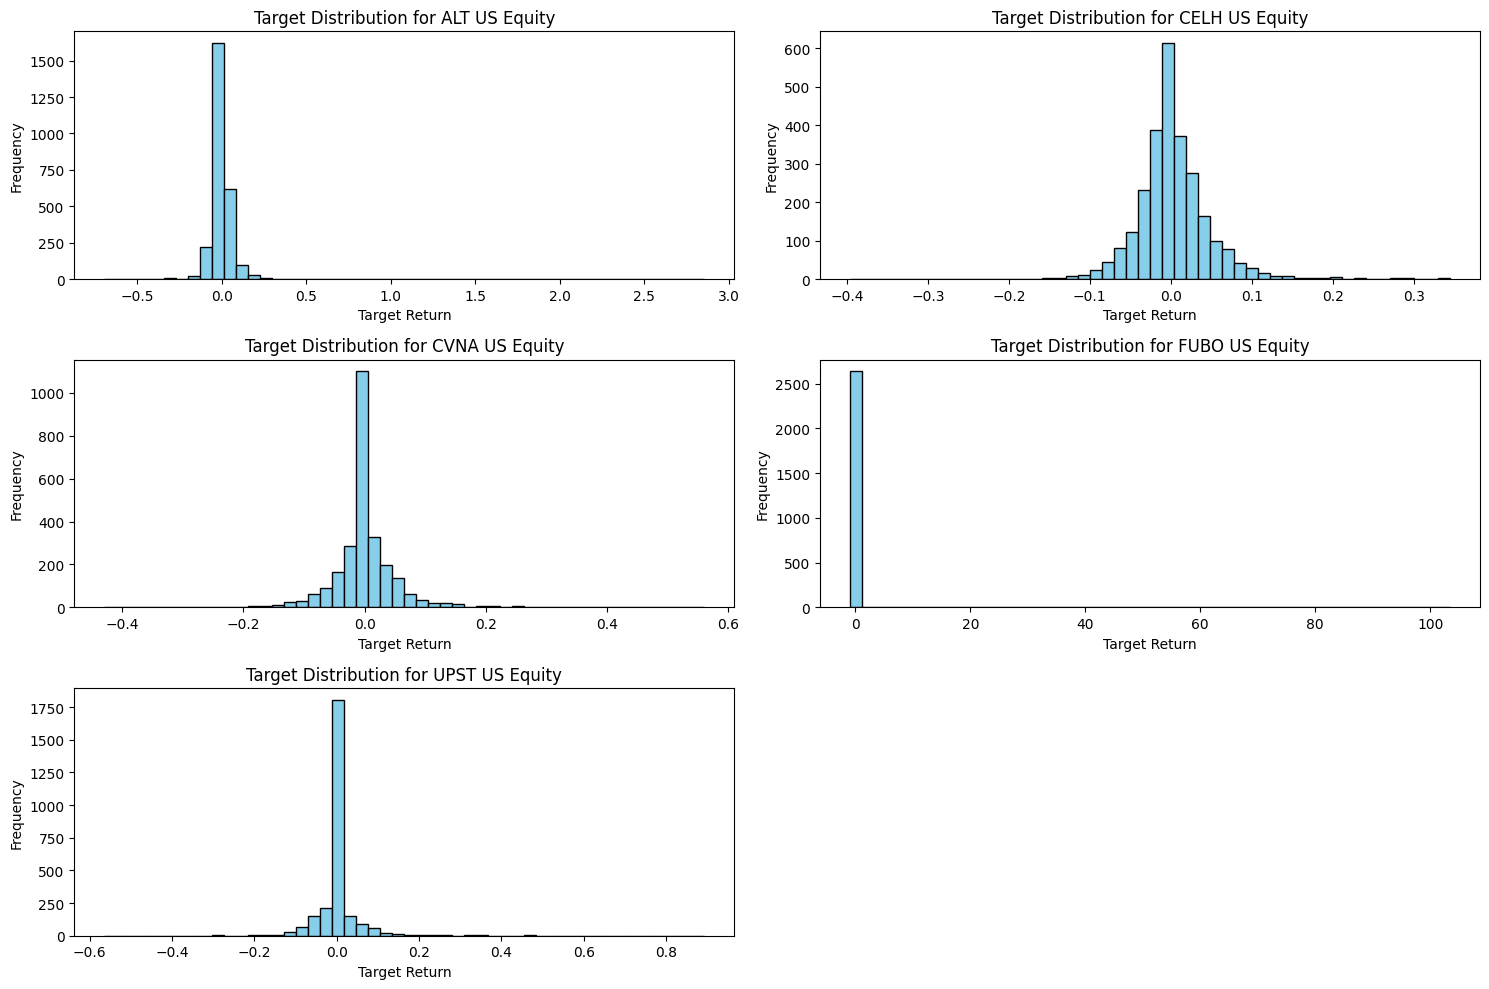

In [23]:

import matplotlib.pyplot as plt

def plot_target_distribution(df):
    stocks = df['Stock'].unique()
    plt.figure(figsize=(15, 10))
    for i, stock in enumerate(stocks, 1):
        stock_df = df[df['Stock'] == stock].copy()
        # Assuming 'target' was created in prepare_data_for_modeling, if not, we can compute it here:
        # For a quick estimate, we define target as the percentage change in 'Last Price'
        if 'target' not in stock_df.columns:
            stock_df['target'] = stock_df['Last Price'].pct_change().shift(-5)  # 5-day ahead return
        plt.subplot(3, 2, i)
        plt.hist(stock_df['target'].dropna(), bins=50, color='skyblue', edgecolor='black')
        plt.title(f"Target Distribution for {stock}")
        plt.xlabel("Target Return")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Run the plot on your processed data
plot_target_distribution(processed_df)


Trying to fix FUBO

In [19]:
import numpy as np

def clip_outliers_by_iqr(stock_df, col="target", iqr_factor=1.5):
    """
    Clips values in 'col' outside [Q1 - iqr_factor*IQR, Q3 + iqr_factor*IQR].
    """
    q1 = stock_df[col].quantile(0.25)
    q3 = stock_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr

    # Clip the values
    stock_df[col] = np.clip(stock_df[col], lower_bound, upper_bound)
    return stock_df

def apply_outlier_clipping(df, col="target"):
    """
    Applies IQR-based outlier clipping to each stock in the DataFrame.
    """
    df_clipped = df.copy()
    for stock in df_clipped['Stock'].unique():
        mask = (df_clipped['Stock'] == stock)
        df_clipped.loc[mask] = clip_outliers_by_iqr(df_clipped.loc[mask], col)
    return df_clipped


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def clip_outliers_by_iqr(series, iqr_factor=1.5):
    """
    Clips outliers in the series using the Interquartile Range (IQR) method.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr

    return np.clip(series, lower_bound, upper_bound)

def prepare_data_for_modeling(self, df: pd.DataFrame, window_size: int = 252,
                              val_size: int = 63, test_size: int = 21, target_days: int = 5) -> Tuple[Dict[str, np.ndarray], ...]:
    """
    Prepare data for modeling using rolling windows approach.

    Args:
        df: Processed DataFrame
        window_size: Number of days for training window
        val_size: Number of days for validation
        test_size: Number of days for testing
        target_days: Number of days ahead to predict
    """
    feature_cols = [
        # Price features
        'Last Price', 'Open Price', 'High Price', 'Low Price',
        'Moving Average 20 Day', 'Moving Average 50 Day', 'Moving Average 200 Day',

        # Volume features
        'Volume', 'Average Volume 30 Day',

        # Technical indicators
        'RSI 14 Day', 'Volatility 30 Day',
        'ROC_5', 'ROC_10', 'ROC_20',
        'MACD', 'MACD_Signal', 'MACD_Diff',
        'BB_High', 'BB_Mid', 'BB_Low', 'BB_Width', 'ATR',
        'OBV', 'ADI',

        # Derived features
        'Daily_Return', 'Log_Return', 'High_Low_Range',
        'Price_MA_Ratio_20', 'Price_MA_Ratio_50', 'Price_MA_Ratio_200',
        'Distance_To_MA_20', 'Distance_To_MA_50',
        'Volume_MA_Ratio', 'Volume_Price_Trend'
    ]

    X_train_dict = {}
    X_val_dict = {}
    X_test_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    y_test_dict = {}

    for stock in df['Stock'].unique():
        # Get data for this stock
        stock_df = df[df['Stock'] == stock].copy()
        stock_df = stock_df.sort_values('Dates')

        # Create target variable (future returns)
        stock_df['target'] = stock_df['Last Price'].shift(-target_days) / stock_df['Last Price'] - 1

        # **Apply outlier clipping on target before splitting**
        stock_df['target'] = clip_outliers_by_iqr(stock_df['target'])

        # Get the last window of data
        total_size = window_size + val_size + test_size
        final_window = stock_df.iloc[-total_size:].copy()

        # Split into train/val/test
        train_data = final_window.iloc[:window_size]
        val_data = final_window.iloc[window_size:window_size + val_size]
        test_data = final_window.iloc[window_size + val_size:]

        # Scale features using only training data
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_data[feature_cols])
        val_features = scaler.transform(val_data[feature_cols])
        test_features = scaler.transform(test_data[feature_cols])

        # **Ensure target is assigned after clipping**
        y_train = train_data['target'].fillna(0).values
        y_val = val_data['target'].fillna(0).values
        y_test = test_data['target'].fillna(0).values

        # Store splits
        X_train_dict[stock] = train_features
        X_val_dict[stock] = val_features
        X_test_dict[stock] = test_features
        y_train_dict[stock] = y_train
        y_val_dict[stock] = y_val
        y_test_dict[stock] = y_test

        # Print info about the splits
        print(f"\nSplit info for {stock}:")
        print(f"Training period: {train_data['Dates'].iloc[0]} to {train_data['Dates'].iloc[-1]}")
        print(f"Validation period: {val_data['Dates'].iloc[0]} to {val_data['Dates'].iloc[-1]}")
        print(f"Test period: {test_data['Dates'].iloc[0]} to {test_data['Dates'].iloc[-1]}")
        print(f"Training samples: {len(train_features)}")
        print(f"Validation samples: {len(val_features)}")
        print(f"Test samples: {len(test_features)}")

    return (X_train_dict, X_val_dict, X_test_dict, y_train_dict, y_val_dict, y_test_dict)


In [24]:


final_predictions = {}

# Loop over each stock's test set
for stock in X_test_dict.keys():
    # Get the test features for this stock (assumed to be the most recent window)
    X_latest = X_test_dict[stock]

    pred_returns = model.predict(X_latest)

    final_pred_return = pred_returns[-1]  # Using the last prediction

    last_price = processed_df[processed_df['Stock'] == stock]['Last Price'].iloc[-1]

    # Convert the predicted return to a forecasted price.
    predicted_price = last_price * (1 + final_pred_return)

    final_predictions[stock] = {
        "predicted_5day_return": final_pred_return,
        "predicted_price": predicted_price
    }

# Print out the final predictions
print("Final Predictions (for the next 5-day period):")
for stock, preds in final_predictions.items():
    print(f"{stock}: Predicted 5-day return = {preds['predicted_5day_return']:.4f} "
          f"({preds['predicted_5day_return']*100:.2f}%), "
          f"Predicted price = ${preds['predicted_price']:.2f}")


Final Predictions (for the next 5-day period):
ALT US Equity: Predicted 5-day return = 0.0457 (4.57%), Predicted price = $6.72
CELH US Equity: Predicted 5-day return = 0.1609 (16.09%), Predicted price = $37.87
CVNA US Equity: Predicted 5-day return = -0.0319 (-3.19%), Predicted price = $216.18
FUBO US Equity: Predicted 5-day return = 0.0921 (9.21%), Predicted price = $4.11
UPST US Equity: Predicted 5-day return = 0.0128 (1.28%), Predicted price = $72.69


In [25]:
evaluation_results = {}

print("Evaluation Metrics on Test Sets:")
for stock in X_test_dict.keys():
    metrics = model.evaluate(X_test_dict[stock], y_test_dict[stock])
    evaluation_results[stock] = metrics
    print(f"{stock}: MAE = {metrics['mae']:.4f}, RMSE = {metrics['rmse']:.4f}, R2 = {metrics['r2']:.4f}")

Evaluation Metrics on Test Sets:
ALT US Equity: MAE = 0.0601, RMSE = 0.0703, R2 = -1.1468
CELH US Equity: MAE = 0.2153, RMSE = 0.2271, R2 = -2.1038
CVNA US Equity: MAE = 0.0710, RMSE = 0.0782, R2 = -0.4286
FUBO US Equity: MAE = 0.0947, RMSE = 0.1110, R2 = -0.7557
UPST US Equity: MAE = 0.0968, RMSE = 0.1218, R2 = 0.1349


In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Best hyperparameters from hyperparameter tuning ===
best_trial_params = {
    "catboost_iterations": 677,
    "catboost_lr": 0.02108262128963427,
    "catboost_depth": 7,
    "catboost_l2_leaf_reg": 4,
    "lgbm_n_estimators": 668,
    "lgbm_lr": 0.09671409581418867,
    "lgbm_num_leaves": 33,
    "lgbm_feature_fraction": 0.8628918652898527,
    "lgbm_subsample": 0.9878992985131347,
    "nn_hidden_dim1": 96,
    "nn_hidden_dim2": 124,
    "nn_lr": 0.0013365869940667667,
    "nn_batch_size": 64,
    "nn_epochs": 21
}

# Define Neural Network class using best hyperparameters
class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, best_trial_params["nn_hidden_dim1"])
        self.fc2 = nn.Linear(best_trial_params["nn_hidden_dim1"], best_trial_params["nn_hidden_dim2"])
        self.fc3 = nn.Linear(best_trial_params["nn_hidden_dim2"], 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Ensemble weights (from your previous tuning; adjust if needed)
weight_cat = 0.6742
weight_lgb = 0.2760
weight_nn  = 0.0498

final_predictions = {}      # To store final predicted 5-day return per stock
predicted_prices = {}       # To store final predicted price per stock
evaluation_metrics = {}     # To store evaluation metrics per stock

# Loop over each stock in the test dictionary
for stock in X_test_dict.keys():
    print(f"\nProcessing stock: {stock}")

    # Get training and test data for this stock
    X_train_stock = X_train_dict[stock]
    y_train_stock = y_train_dict[stock]
    X_test_stock  = X_test_dict[stock]
    y_test_stock  = y_test_dict[stock]

    input_dim = X_train_stock.shape[1]

    # --- Train CatBoost for this stock ---
    cat_model = CatBoostRegressor(
        iterations=best_trial_params["catboost_iterations"],
        learning_rate=best_trial_params["catboost_lr"],
        depth=best_trial_params["catboost_depth"],
        l2_leaf_reg=best_trial_params["catboost_l2_leaf_reg"],
        loss_function="RMSE",
        verbose=0
    )
    cat_model.fit(X_train_stock, y_train_stock)

    # --- Train LightGBM for this stock ---
    lgb_model = lgb.LGBMRegressor(
        n_estimators=best_trial_params["lgbm_n_estimators"],
        learning_rate=best_trial_params["lgbm_lr"],
        num_leaves=best_trial_params["lgbm_num_leaves"],
        feature_fraction=best_trial_params["lgbm_feature_fraction"],
        subsample=best_trial_params["lgbm_subsample"]
    )
    lgb_model.fit(X_train_stock, y_train_stock)

    # --- Train Neural Network for this stock ---
    nn_model = NeuralNet(input_dim)
    optimizer = optim.Adam(nn_model.parameters(), lr=best_trial_params["nn_lr"])
    criterion = nn.MSELoss()

    # Convert training data to tensors
    X_train_tensor = torch.tensor(X_train_stock, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_stock, dtype=torch.float32).view(-1, 1)

    nn_model.train()
    for epoch in range(best_trial_params["nn_epochs"]):
        optimizer.zero_grad()
        outputs = nn_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # --- Predictions on test set for this stock ---
    cat_preds = cat_model.predict(X_test_stock)         # numpy array
    lgb_preds = lgb_model.predict(X_test_stock)           # numpy array
    nn_model.eval()
    nn_preds = nn_model(torch.tensor(X_test_stock, dtype=torch.float32)).detach().numpy().flatten()

    # Weighted ensemble predictions for each test sample
    ensemble_preds = (cat_preds * weight_cat) + (lgb_preds * weight_lgb) + (nn_preds * weight_nn)

    # Use the last sample's prediction as the forecasted 5-day return
    final_return = ensemble_preds[-1]
    final_predictions[stock] = final_return

    # Get the last known price for this stock from processed_df
    last_price = processed_df[processed_df['Stock'] == stock]['Last Price'].iloc[-1]
    predicted_price = last_price * (1 + final_return)
    predicted_prices[stock] = predicted_price

    # --- Evaluate predictions on test set ---
    mae = mean_absolute_error(y_test_stock, ensemble_preds)
    rmse = np.sqrt(mean_squared_error(y_test_stock, ensemble_preds))
    r2 = r2_score(y_test_stock, ensemble_preds)
    evaluation_metrics[stock] = {"MAE": mae, "RMSE": rmse, "R2": r2}

# --- Print final predictions and evaluation metrics ---
print("\nFinal Predictions (Using Best Hyperparameters from Tuning):")
for stock in final_predictions.keys():
    print(f"{stock}: Predicted 5-day return = {final_predictions[stock]*100:.2f}%, Predicted price = ${predicted_prices[stock]:.2f}")

print("\nEvaluation Metrics on Test Sets:")
for stock, metrics in evaluation_metrics.items():
    print(f"{stock}: MAE = {metrics['MAE']:.4f}, RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}")



Processing stock: ALT US Equity

Processing stock: CELH US Equity

Processing stock: CVNA US Equity

Processing stock: FUBO US Equity

Processing stock: UPST US Equity

Final Predictions (Using Best Hyperparameters from Tuning):
ALT US Equity: Predicted 5-day return = 9.28%, Predicted price = $7.03
CELH US Equity: Predicted 5-day return = -4.93%, Predicted price = $31.01
CVNA US Equity: Predicted 5-day return = 7.94%, Predicted price = $241.02
FUBO US Equity: Predicted 5-day return = -7.20%, Predicted price = $3.49
UPST US Equity: Predicted 5-day return = -0.59%, Predicted price = $71.35

Evaluation Metrics on Test Sets:
ALT US Equity: MAE = 0.0963, RMSE = 0.1016, R2 = -3.4892
CELH US Equity: MAE = 0.1229, RMSE = 0.1471, R2 = -0.3019
CVNA US Equity: MAE = 0.0743, RMSE = 0.0963, R2 = -1.1688
FUBO US Equity: MAE = 0.1069, RMSE = 0.1221, R2 = -1.1256
UPST US Equity: MAE = 0.0939, RMSE = 0.1345, R2 = -0.0545
